**1 - Introduction**


This colab focuses on training a face recognition model that can effectively recognize faces in images containing masks. The model utilizes Deep Metric Learning techniques, specifically a Triplet Network model, and leverages a dataset comprising celebrities' faces. The Triplet Network learns an embedding space where similar faces are grouped closely together, while dissimilar faces are pushed further apart.

During training, the model is optimized using the triplet loss function, which aims to minimize the distance between embeddings of masked and unmasked images of the same person, while maximizing the distance between embeddings of different individuals. This approach enables the model to effectively learn and recognize faces even when masks are present.


In [11]:

import torch
import os
import torchvision
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision.transforms import transforms
from PIL import Image
import pandas as pd
import numpy as np

In [12]:
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [13]:
#First we are going to extract the dataset

import zipfile
zip_path = "/content/drive/MyDrive/daedalus/celebrities.zip"
extract_dir = "/content/drive/MyDrive/daedalus/extract"

with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_dir)

To coupe with this Deep Metric Learning problem, the architeture that is going to be used is the Triplet Network.



> A Triplet network is a neural network architecture that consists of three identical subnetworks that share the same set of parameters. The learning is performed on a set of three images:


1.   Anchor Image (base): The reference image or the image for which we want to learn the representation.
2.   Positive Image: Images of the same person that belong to the same class as the anchor
3.   Negative Image: Images that do not belong to the same class as the anchor.

The main goal is to minimize the distance between the Anchor Image and Positive image and to maximize their distance to the negative image




**1. Separating the dataset in triplets [anchor,positive,negative] for each celebrity.**


> Obs: Celebrities with only one photo will not be considered to be a triplet


> Obs2: The folders are selected randomly, as well as it imagens inside of each folder, although the folder of positives and anchor can't be the same as the negative folder





In [14]:
import os
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

def generate_triplets(dataset_dir, num_triplets=10000):
    """
    Function to generate [anchor, positive, negative] triplets for training, returns the triplets.
    """
    triplets = []
    #get the list of folders ion the data set
    labels = os.listdir(dataset_dir)
    #the label (foider) needs to have at least 2 images for anchor and positive
    labels_with_enough_imgs = [label for label in labels if len(os.listdir(os.path.join(dataset_dir, label))) >= 2]
    #the negative needs to have at least one image
    labels_with_imgs = [label for label in labels if len(os.listdir(os.path.join(dataset_dir, label))) >= 1]

    #This loop will continue until the hyperparameters num_triplets is reached
    while True:
        #random select the anchor label (folder)
        anchor_label = np.random.choice(labels_with_enough_imgs)
        positive_label = anchor_label  # positive and anchor are from the same class

        #The negative label shouldn't be the same as the positive label
        possible_negative_labels = [label for label in labels_with_imgs if label != anchor_label]
        #random select the negative label from all possible labels
        negative_label = np.random.choice(possible_negative_labels)

        #Select random images in anchor label to be anchor and positive images
        anchor_img, positive_img = np.random.choice(os.listdir(os.path.join(dataset_dir, anchor_label)), 2, replace=False)
        #Select random images in negative label to be the negative image
        negative_img = np.random.choice(os.listdir(os.path.join(dataset_dir, negative_label)))

        triplets.append([os.path.join(dataset_dir, anchor_label, anchor_img),
                         os.path.join(dataset_dir, anchor_label, positive_img),
                         os.path.join(dataset_dir, negative_label, negative_img)])

        if len(triplets) > num_triplets:
          break

    return triplets

def visualize_triplets(triplets, num_triplets=5):
    """
    Helper function to visualize anchor, positive and negative images.
    """
    for i in range(num_triplets):
        _, axs = plt.subplots(1, 3, figsize=(10, 2))

        for i, img_path in enumerate(triplets[i]):
            img = mpimg.imread(img_path)
            axs[i].imshow(img)
            axs[i].set_title(["Anchor", "Positive", "Negative"][i])

        plt.show()




In [15]:
from sklearn.model_selection import train_test_split
dataset_dir = '/content/drive/MyDrive/daedalus/extract/post-processed'

triplets = generate_triplets('/content/drive/MyDrive/daedalus/extract/post-processed')


['/content/drive/MyDrive/daedalus/extract/post-processed/Bixente_LIzarazu/Bixente_LIzarazu_0001_0000.jpg', '/content/drive/MyDrive/daedalus/extract/post-processed/Bixente_LIzarazu/Bixente_LIzarazu_0004_0000.jpg', '/content/drive/MyDrive/daedalus/extract/post-processed/Patricia_Clarkson/Patricia_Clarkson_0003_0002.jpg']


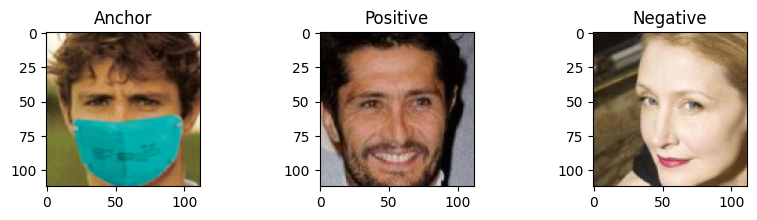

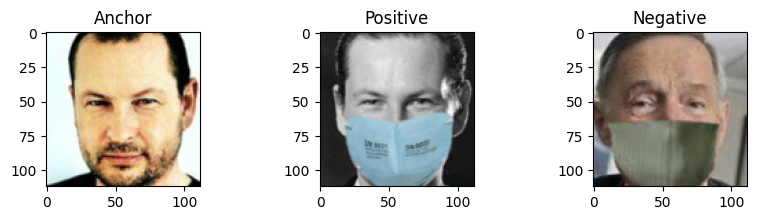

In [16]:
#Visualize some triplets to check if everything is okay
print(triplets[0])
visualize_triplets(triplets,num_triplets = 2)

In [18]:
#Split triplets sets between train and test
from sklearn.model_selection import train_test_split
train_triplets, test_triplets = train_test_split(triplets, test_size=0.2)

**2. Now the training model will be created**


> The base network for future feature extraction will be constructed from a popular pre-trained(for computation purposes) deep learning model, the ResNet50 model.



> To measure the distance between the images vectors, will use the Euclidian Distance

$$
d(\mathbf{image\_vector1}, \mathbf{image\_vector2}) = \sqrt{\sum_{i=1}^{n} (image\_vector2_i - image\_vector1_i)^2}
$$







In [19]:


import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Flatten, Dense, Dropout, Lambda
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.python.keras.backend import l2_normalize



def create_base_network(input_shape):
    """
    Base network to be shared (eq. to feature extraction).
    """
    #Creates the model with the ResNet DL model. include_top is set to false for prevente its original classification
    model = ResNet50(weights='imagenet', include_top=False, input_shape=input_shape)
    #Will freeze the weights updating of the network for computation purposes
    model.trainable = False
    return model

def euclidean_distance(image_vectors):
    """
    Euclidean distance as a measure of similarity between the anchor, positive, and negative images.
    Return the distances
    """
    anchor, positive, negative = image_vectors[0], image_vectors[1], image_vectors[2]

    #euclidian distance between the vectors
    anchor_positive_dist = tf.sqrt(tf.reduce_sum(tf.square(anchor - positive), axis=1))
    anchor_negative_dist = tf.sqrt(tf.reduce_sum(tf.square(anchor - negative), axis=1))

    #Not necessary, for now
    #positive_negative_dist = tf.sqrt(tf.reduce_sum(tf.square(positive - negative), axis=1))

    return [anchor_positive_dist, anchor_negative_dist]




#Will use this input shapes as is the common shapes for the ResNet networks.
input_shape = (224, 224, 3)


base_network = create_base_network(input_shape)
input_anchor = Input(shape=input_shape)
input_positive = Input(shape=input_shape)
input_negative = Input(shape=input_shape)

# As seen before, this architeture has 3 networks, and they are siamesis, so they have all the same weigth and characteristics
processed_anchor = base_network(input_anchor)
processed_positive = base_network(input_positive)
processed_negative = base_network(input_negative)

# Calculate the distance to each triplet
distance = Lambda(euclidean_distance)([processed_anchor, processed_positive, processed_negative])

# Define the model
model = Model(inputs=[input_anchor, input_positive, input_negative], outputs=distance)


In [20]:
from tensorflow.keras.preprocessing.image import load_img, img_to_array

def data_generator(triplets, batch_size=32):

  """
  Form batch of numpy arrays for the training

  """
  while True:
      # Randomly select 'batch_size' triplets
      indices = np.random.choice(np.arange(len(triplets)), size=batch_size)
      batch_triplets = np.array(triplets)[indices]

      anchor_images = []
      positive_images = []
      negative_images = []

      for triplet in batch_triplets:
          anchor_images.append(img_to_array(load_img(triplet[0])))
          positive_images.append(img_to_array(load_img(triplet[1])))
          negative_images.append(img_to_array(load_img(triplet[2])))

      # Normalize to [0,1]
      anchor_images = np.array(anchor_images) / 255.
      positive_images = np.array(positive_images) / 255.
      negative_images = np.array(negative_images) / 255.

      yield [anchor_images, positive_images, negative_images], np.zeros((batch_size, 3))


In [21]:
# Define triplet loss
def triplet_loss(y_true, y_pred):
    "Calculate and return the triplet loss"
    margin = 1

    anchor_positive_dist = y_pred[:, 0]
    anchor_negative_dist = y_pred[:, 1]

    #Subtracting the anchor to positive distance from the anchor to negative distance we maximize the first and minize the second
    #which is the main goal of the algorithm
    loss = tf.maximum(anchor_positive_dist - anchor_negative_dist + margin, 0)

    return loss




model.compile(loss=triplet_loss, optimizer=Adam())



history = model.fit(data_generator(train_triplets, batch_size=32),
                    steps_per_epoch=10,
                    epochs=10,
                    validation_data=data_generator(test_triplets, batch_size=32),
                    validation_steps=10)


Epoch 1/10
10/10 [==============================] - 14s 653ms/step - loss: 1.9168 - lambda_1_loss: 0.9604 - lambda_1_1_loss: 0.9564 - val_loss: 1.9143 - val_lambda_1_loss: 0.9595 - val_lambda_1_1_loss: 0.9548
Epoch 2/10
10/10 [==============================] - 4s 384ms/step - loss: 1.9141 - lambda_1_loss: 0.9589 - lambda_1_1_loss: 0.9551 - val_loss: 1.9124 - val_lambda_1_loss: 0.9576 - val_lambda_1_1_loss: 0.9548
Epoch 3/10
10/10 [==============================] - 4s 425ms/step - loss: 1.9137 - lambda_1_loss: 0.9592 - lambda_1_1_loss: 0.9545 - val_loss: 1.9085 - val_lambda_1_loss: 0.9552 - val_lambda_1_1_loss: 0.9533
Epoch 4/10
10/10 [==============================] - 4s 389ms/step - loss: 1.9138 - lambda_1_loss: 0.9585 - lambda_1_1_loss: 0.9553 - val_loss: 1.9145 - val_lambda_1_loss: 0.9595 - val_lambda_1_1_loss: 0.9550
Epoch 5/10
10/10 [==============================] - 4s 391ms/step - loss: 1.9140 - lambda_1_loss: 0.9591 - lambda_1_1_loss: 0.9549 - val_loss: 1.9122 - val_lambda_1_lo

3. Next step is to predict every image in the trained model to append its predicted description vector

In [22]:
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import pickle
import os

# Create a dictionary to store descriptor vectors
descriptor_vectors = {}
dataset_dir = '/content/drive/MyDrive/daedalus/extract/post-processed'

# Configure ImageDataGenerator for image normalization
datagen = ImageDataGenerator(rescale=1./255)

# Iterate through each folder in the dataset directory
for folder_name in os.listdir(dataset_dir):
    folder_path = os.path.join(dataset_dir, folder_name)
    if not os.path.isdir(folder_path):
        continue

    #just for progress purposes
    print(folder_name)


    image_files = os.listdir(folder_path)


    # Iterate through each file in the folder
    for image_path in os.listdir(folder_path):


        # Get the full file path
        image_file_path = os.path.join(folder_path, image_path)

        # Load the image
        image = load_img(image_file_path, target_size=(224, 224))
        image = img_to_array(image)
        image = image / 255.  # Normalize the image

        # Expand dimensions to match the expected input shape of the model
        image = np.expand_dims(image, axis=0)

        # Use the model to generate a descriptor vector for the image
        descriptor = base_network.predict(image)

        # Save the descriptor vector in the dictionary using the file name as the key
        descriptor_vectors[image_path] = descriptor

# Save the descriptor vectors dictionary to a database file
with open('descriptor_vectors.pickle', 'wb') as handle:
    pickle.dump(descriptor_vectors, handle, protocol=pickle.HIGHEST_PROTOCOL)


Streaming output truncated to the last 5000 lines.
1/1 [==============================] - 0s 26ms/step
Adam_Mair
1/1 [==============================] - 0s 23ms/step
Adam_Rich
1/1 [==============================] - 0s 24ms/step
Adam_Sandler
1/1 [==============================] - 0s 25ms/step
Adolfo_Aguilar_Zinser
1/1 [==============================] - 0s 23ms/step
Adolfo_Rodriguez_Saa
1/1 [==============================] - 0s 26ms/step
Adoor_Gopalakarishnan
1/1 [==============================] - 0s 25ms/step
Adrian_Annus
1/1 [==============================] - 0s 24ms/step
Adrian_Fernandez
1/1 [==============================] - 0s 27ms/step
Adrian_Murrell
1/1 [==============================] - 0s 25ms/step
Adrian_Nastase
1/1 [==============================] - 0s 24ms/step
Adrien_Brody
1/1 [==============================] - 0s 24ms/step
Afton_Smith
1/1 [==============================] - 0s 22ms/step
Agnelo_Queiroz
1/1 [==============================] - 0s 23ms/step
Ahmed_Ahmed
1/1 [======

**4. Next step is to add the new image into the dataset**

---



In [26]:
import gdown
from tensorflow.keras.preprocessing.image import load_img, img_to_array

image_url = "https://lh3.googleusercontent.com/fife/APg5EOZ6j9B5Cv7Uwq9pLoEevvW9aVLi74nMDixN2VIZ3IuqUuUjXxGZk_ZFNvn9wMm2w-r305LT5Z1uzQlFYMFrlTCYNLGArPuzLNOxEigGfPenEhMPXX9Knjk4y_bv3Bv29BcPPTmLjrO6L6-IRmVQnao0bfXV-nAr5KY52GmGXAzv77ZRf6C8iAqPs-o8jQOBNf4hQ45mQrFyhj_l-C9W9S_ctw8107NKLcNmW0ntg_4xRSdruGveC1CdPLWSw3kcxaDJbbruYFg6OeDsnupAOPtN-8HV8QKmfFeb6I2yxcwwwPr1Lqkx0Np_XHVRgWkVF-QaB7U80l_qhcwT6EIO5HK1giAhHQkPfWAEUTWk5h10AgZTDIv13Mz4CXiiQH4WG1Fa8SBcUMFEFYeu307F8CaWJdcX1dihIGiRCRwdGhmnbMqyD0ca3BswvSJeOafyZx0pGK1PTiSR_L0topHdB4wv3Or4qqI0Lwb8PDm6yorvAB4RHlfpmgv0VbHH97yGchvHjpEDplNFkHwhb0AR_5T0swQjEZgDrD2XNpueJBuHIOvIWNrAm7xQuGro7AyX0w0iNIChHhJ_LF_hs8Eussmdd5FBRitMGFETiVYvliGWKpmhuXrrnO60Ob6E7nzm_zUNm25wDUHzYFeZvPd7jiCtZtQlS1lmKHdTPoit2Dv5RfaWmATbJoS7LCoCVkuVoejcIB4lXNTy9Uw1RdlZFH2ayCxSXWJnF_UCv0puWIf7TAAoIEsV8tIne00sLFaeRTDcjjR1gzYukXRcPeZxdfJyROuiQ7ncNJM39kN332sQV4mmNYgNVlsR05R2Mf_c6n8tgf4WSoiGPwwvt9De9JZz5xIIbL0He-YQGt-hfkmBM_cK3z-4iEu81RQvTzPAZxr2fS3K95ErAPGQc3baDNbXbnIrejtUPrMkKreFnY6yU2C7A5Y6ZTMNjBBmw7L2NJixofFsUm_NDCEXLlLWm_vUY-xlfjwZttCF6fhQ0D-6AtqyCajZ2EgCI5AIenBhhkJVrvuXClc6iez58LdSNJmOBimawtpO_o_Abjm0OilC5nqLZa4biNwm6UGtuK8kV7RwyXdI2Tuo9ZgUKksrHUGI-DhBOj3-4WuN4DP2v6xIIDTY-NfaUq5vwADGuHUx8qvm-Mn2C8O2_Hj8eKVp9qbQztssUZvaPu5P-7SZstqpT-XtIR9w0b4g8KofOnsv1wKFOnfC1YFGxgWzCWbunhQiaIj-7LCM3fo89hsaYVcPvXed7Etlej1ojd1Wf9yXp9sGw9VZn3f70iNoHEA2_CdzKERWPWcbfptcQfRtRcn0z-yFZgh6J9TGf8vTJmv8Qp1J7uI55LyqzXD7yQ0XIcRlGbPdjs8Rbt_XqUyE2PDav0qKtekDZYIvtL5HR4_zj5V7VpTj5WR02R-nkG7H2IWN_PhRhS1c9b9gglZBdmXSEFMS0yzLo1yx6hJpHw0uTk_ESD7ufSIw9V5s1eVyyaZ3C9uv6U1aCO6OChtaGf6oDucZyxDpBImgbwitf4BKyAjeZFzqAtK5TUGtWEURTAyqSZ2PPS40b_kffxc=w1920-h931"

#Save the image
image_path = "/content/drive/MyDrive/daedalus/image.jpg"
gdown.download(image_url, image_path, quiet=False)


#Lod the image adjusting its dimensions
new_image = img_to_array(load_img(image_path, target_size=(224, 224))) / 255.0
new_image = np.expand_dims(new_image, axis=0)

#Predict its description vector using the network
new_descriptor = base_network.predict(new_image)

#Save the vector in the database vector
descriptor_vectors[image_url] = new_descriptor



#Save it in the database file
with open('descriptor_vectors.pickle', 'wb') as handle:
    pickle.dump(descriptor_vectors, handle, protocol=pickle.HIGHEST_PROTOCOL)


Downloading...
From: https://lh3.googleusercontent.com/fife/APg5EOZ6j9B5Cv7Uwq9pLoEevvW9aVLi74nMDixN2VIZ3IuqUuUjXxGZk_ZFNvn9wMm2w-r305LT5Z1uzQlFYMFrlTCYNLGArPuzLNOxEigGfPenEhMPXX9Knjk4y_bv3Bv29BcPPTmLjrO6L6-IRmVQnao0bfXV-nAr5KY52GmGXAzv77ZRf6C8iAqPs-o8jQOBNf4hQ45mQrFyhj_l-C9W9S_ctw8107NKLcNmW0ntg_4xRSdruGveC1CdPLWSw3kcxaDJbbruYFg6OeDsnupAOPtN-8HV8QKmfFeb6I2yxcwwwPr1Lqkx0Np_XHVRgWkVF-QaB7U80l_qhcwT6EIO5HK1giAhHQkPfWAEUTWk5h10AgZTDIv13Mz4CXiiQH4WG1Fa8SBcUMFEFYeu307F8CaWJdcX1dihIGiRCRwdGhmnbMqyD0ca3BswvSJeOafyZx0pGK1PTiSR_L0topHdB4wv3Or4qqI0Lwb8PDm6yorvAB4RHlfpmgv0VbHH97yGchvHjpEDplNFkHwhb0AR_5T0swQjEZgDrD2XNpueJBuHIOvIWNrAm7xQuGro7AyX0w0iNIChHhJ_LF_hs8Eussmdd5FBRitMGFETiVYvliGWKpmhuXrrnO60Ob6E7nzm_zUNm25wDUHzYFeZvPd7jiCtZtQlS1lmKHdTPoit2Dv5RfaWmATbJoS7LCoCVkuVoejcIB4lXNTy9Uw1RdlZFH2ayCxSXWJnF_UCv0puWIf7TAAoIEsV8tIne00sLFaeRTDcjjR1gzYukXRcPeZxdfJyROuiQ7ncNJM39kN332sQV4mmNYgNVlsR05R2Mf_c6n8tgf4WSoiGPwwvt9De9JZz5xIIbL0He-YQGt-hfkmBM_cK3z-4iEu81RQvTzPAZxr2fS3K95ErAPGQc3baDNbXbnIrejtUPrMkKreF

1/1 [==============================] - 0s 25ms/step


**5.The final step is to train the test image and compare its vector distance with all the vectors in the database, the most similar image will be the one with the minimum distance**

Test image


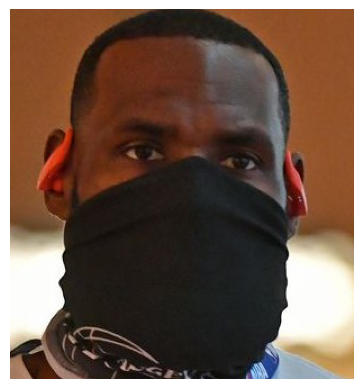

Downloading...
From: https://lh3.googleusercontent.com/fife/APg5EOZ6j9B5Cv7Uwq9pLoEevvW9aVLi74nMDixN2VIZ3IuqUuUjXxGZk_ZFNvn9wMm2w-r305LT5Z1uzQlFYMFrlTCYNLGArPuzLNOxEigGfPenEhMPXX9Knjk4y_bv3Bv29BcPPTmLjrO6L6-IRmVQnao0bfXV-nAr5KY52GmGXAzv77ZRf6C8iAqPs-o8jQOBNf4hQ45mQrFyhj_l-C9W9S_ctw8107NKLcNmW0ntg_4xRSdruGveC1CdPLWSw3kcxaDJbbruYFg6OeDsnupAOPtN-8HV8QKmfFeb6I2yxcwwwPr1Lqkx0Np_XHVRgWkVF-QaB7U80l_qhcwT6EIO5HK1giAhHQkPfWAEUTWk5h10AgZTDIv13Mz4CXiiQH4WG1Fa8SBcUMFEFYeu307F8CaWJdcX1dihIGiRCRwdGhmnbMqyD0ca3BswvSJeOafyZx0pGK1PTiSR_L0topHdB4wv3Or4qqI0Lwb8PDm6yorvAB4RHlfpmgv0VbHH97yGchvHjpEDplNFkHwhb0AR_5T0swQjEZgDrD2XNpueJBuHIOvIWNrAm7xQuGro7AyX0w0iNIChHhJ_LF_hs8Eussmdd5FBRitMGFETiVYvliGWKpmhuXrrnO60Ob6E7nzm_zUNm25wDUHzYFeZvPd7jiCtZtQlS1lmKHdTPoit2Dv5RfaWmATbJoS7LCoCVkuVoejcIB4lXNTy9Uw1RdlZFH2ayCxSXWJnF_UCv0puWIf7TAAoIEsV8tIne00sLFaeRTDcjjR1gzYukXRcPeZxdfJyROuiQ7ncNJM39kN332sQV4mmNYgNVlsR05R2Mf_c6n8tgf4WSoiGPwwvt9De9JZz5xIIbL0He-YQGt-hfkmBM_cK3z-4iEu81RQvTzPAZxr2fS3K95ErAPGQc3baDNbXbnIrejtUPrMkKreF

1/1 [==============================] - 0s 25ms/step


 = = = = = The most similar image is: = = = = =


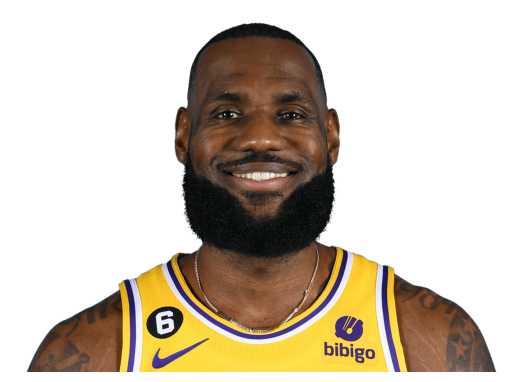

In [27]:
import requests
from io import BytesIO
from PIL import Image



new_image_path = 'https://lh3.googleusercontent.com/fife/APg5EOYjLKnZ6sM9Gbj1cDSlueBVJp-quBD1wmuVWYADi9_eS6hwGLFolGqkCkk4tDVlYIXpfIg4gIOjsy6SO7YDCasDDQyrnMicjLKXJLQZ_2aeDOlr4W9FydJwhIzdRoZ0hAOY2n8sD7txVgIV4FkeqRRdE2zaVZhFzoe05-bZPMMpfPvTBXpQFCFSbLI_SfnVqva-Gq19yRIf_RU_OOkPINAXOZYRnTeSuqgzlbmcjjoj1KZRU3KzpLzRgGXATN1PD_vPd_OGd1-nbk0pXeJC3G0ON5U4r3ebVGfwVHnStcHn-dxGrlV4RAbCW4V-1gxzjmixI5D5cSlyB4WMFceC0aplIxI-JorS3Qvy-i5IWlsxXrKhefVOHaiKFDI4TuzUh4QGTvPgUKWNWM2F7E-jmVoWI3P2ImLcs3_YTD2zUTRKCSGuZWsEUsf88gGohfsvuQvHZjrbS9yrDIJR_repxlXxiZZqH8uc38wFY8n1zfnXfyea0z_dyWy-jx-tnhZbmA2fXkqtKVAzcgjaoGL2IIiT0OvajialhpYIv03ZU8DvxaCp1V85tdHhrUCHhB5L9LTTdwZ126d759gun1b4JSGKNIvYIdcezRjD32OBItwBRMHf44uYuYqC_vXl9v5Avazsn6kwbzPDfZlKBvT0ywf2jxV29_TmJU8YbSOnYYPzdOc0xomIXdjiSH6EooZKUNePCVOAgrFeVYySCJcGGWvGPs-bD7N2lHvmUEGYdEdtiFoBCsue4sceBiiXGSRxVgG_fWznQPC2xV7egoqMwtKEwoqcsrJgK9CWGvk3kfrj28kM6mcdti2Ln2tTDagAWOMu6UO-ZXXBbYEyaKL0D1tkbUCrBQgAZ_XNz4YtfSKSFOb2RS4F4cd4pBkWLqjGbfnvJPm5-AFptBmow9sXHYnXYZiXn9yxhQdw0M-OoGL-6Sx3jJg9JcH3HWcEfy2Xc25Ove4tKGLrwiOMjpTPJ301YLINvF3EFZRmAiZdSbwkktRT5MCTcxgihU9eCeKDsuSm37D7rwmAv_Zo79bHokVqozhDQhNM_xqU4-b2jizfEHJnsbDWysIYPwscDVRj6tNp5Xfu9ypihKkb6JfpPiUtKDJeljIWRkGg5YRuSxySH5CKba5WffC4rYfQPpZw05bKVUdYOwAOysMbi5vBnXRT_rcFMYssD83rClIixaj5O-ueluKOcJjFWkm1MdR5_Z0JWORcc5ZOM_lqOUl5vAzqVjP65b05h_tGJtJUWbnwugAwSWlGRlcyjE1cBUqjTnNZKMx_FB07pO9tEkt5x99LpgbI2Alir4oWzvMA6K1ii1VlLZabTBEU3avspYQ47b7BSV3uFDn0IeBHGRJhl5wvB5mHRpAf8UV-naqxOsK1KMTkicmzJl6HIL4ExcsKpZgiYxY_k8iSQEpADfWCZUi08EBzEbLi9vza_AXG7GOlCDNS48dyLWvIgSlTS10d8d5allbuDE5JovWEHhAiMMkNDjuSjNDRsRhye6HjuvJUBAHMthYF4mEz3fd9lV5oG8EeMr3g6-z1KiXUZXwV_OcaX6d-X_Y7hce5wD0=w1920-h931'
image_path = "/content/drive/MyDrive/daedalus/image_test.jpg"

# Show the image
print("Test image")
response = requests.get(new_image_path)
image = Image.open(BytesIO(response.content))
plt.imshow(image)
plt.axis('off')
plt.show()


gdown.download(image_url, image_path, quiet=False)

# Load and normalize the test image
new_image = img_to_array(load_img(image_path, target_size=(224, 224))) / 255.0
new_image = np.expand_dims(new_image, axis=0)
test_image= new_image

# Predict with the test image
test_descriptor = base_network.predict(test_image)
#Calculate the distance between the images vectors
distances = {image_path: np.linalg.norm(descriptor - test_descriptor) for image_path, descriptor in descriptor_vectors.items()}

#Find the similar image, the one with the minium distance between the vectors
closest_image_path = min(distances, key=distances.get)

print(f" = = = = = The most similar image is: = = = = =")

response = requests.get(closest_image_path)
closest_image = Image.open(BytesIO(response.content))

# Show the image
plt.imshow(closest_image)
plt.axis('off')
plt.show()


**Conclusion**


>As observed in the preceding cells, the model demonstrated the ability to learn and discern facial features behind masks. However, there are still opportunities for further improvement in the architecture and optimization of the triplet loss function, particularly when working with larger datasets.



* To optimize the architecture, one could explore variations of the base network, such as using different pre-trained models or custom convolutional neural network (CNN) architectures. Fine-tuning the base network's weights might be good for the model.

* Regarding the triplet loss function, experimenting with different margin values could lead to improved results

* When working with larger datasets, it becomes important to consider computational efficiency. Implementing batch-wise distance calculations, instead of computing distances between all pairs, can significantly speed up training without compromising performance.

* To optimize the training process, it is crucial to select appropriate hyperparameters. This includes tuning learning rate, batch size, and regularization techniques.







**References**
* A Simple Guide to Deep Metric Learning -
https://www.youtube.com/watch?v=Tjxv8nujSEw

* The Why and the How of Deep Metric Learning : https://towardsdatascience.com/the-why-and-the-how-of-deep-metric-learning-e70e16e199c0

* A beginners guide for metric learning : https://analyticsindiamag.com/a-beginners-guide-to-deep-metric-learning/

* Deep metric learning a survey - https://www.researchgate.net/publication/335314481_Deep_Metric_Learning_A_Survey

* Many github repositories - https://github.com/topics/deep-metric-learning




